In [84]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [85]:
data_dir = '../data/rect_train/'
data_dir = pathlib.Path(data_dir)

image_count_p = len(list(data_dir.glob('primary/*.jpg')))
image_count_r = len(list(data_dir.glob('recurrent/*.jpg')))

print("primary class {}, recurrent class {}".format(image_count_p, image_count_r))

primary class 239, recurrent class 74


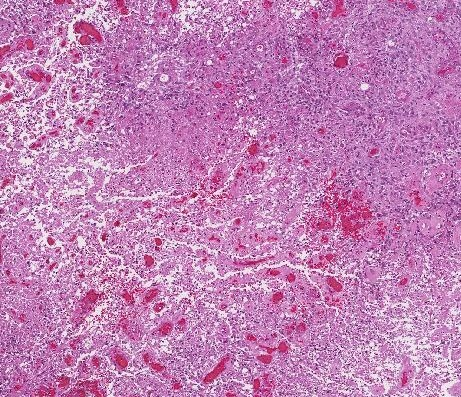

In [86]:
primary = list(data_dir.glob('primary/*'))
PIL.Image.open(str(primary[0]))

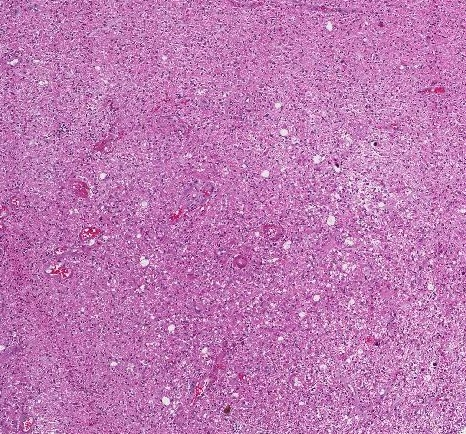

In [87]:

recurrent = list(data_dir.glob('recurrent/*'))
PIL.Image.open(str(recurrent[0]))

In [88]:
batch_size = 32 # 64
img_height = 448 # 224
img_width = 448 # 224

In [89]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 313 files belonging to 2 classes.
Using 220 files for training.


In [90]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 313 files belonging to 2 classes.
Using 93 files for validation.


In [91]:
class_names = train_ds.class_names
print(class_names)

['primary', 'recurrent']


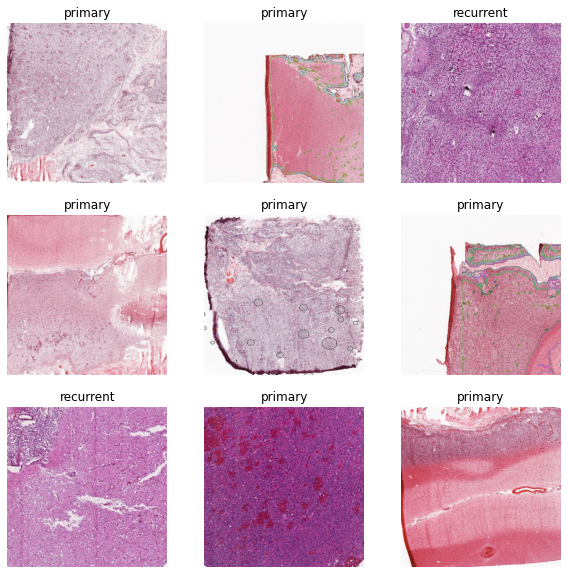

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [93]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 448, 448, 3)
(32,)


In [94]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [95]:
normalization_layer = layers.Rescaling(1./255)

In [96]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0049613984 1.0


In [97]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

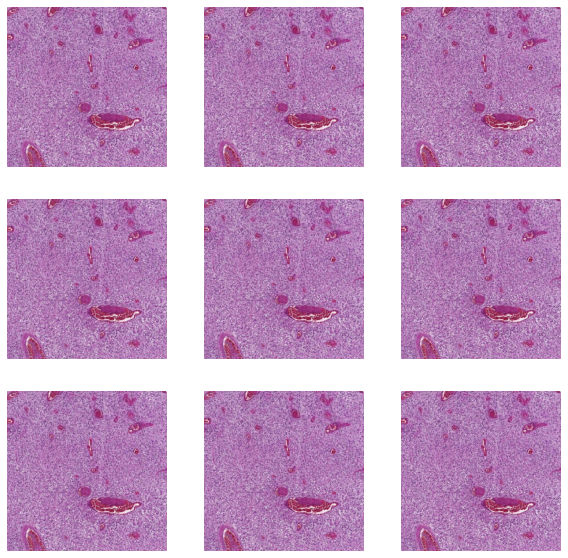

In [98]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [99]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Flatten(),
  layers.Dense(1, activation='sigmoid')
])

In [100]:
from keras.optimizers import SGD

opt = SGD(learning_rate=0.00001, momentum=0.9)

# model.compile(optimizer="adam",
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=['accuracy'])

model.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=['accuracy'])

model.summary()

epochs=200
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

model.save("CNN_sequential.h5")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 448, 448, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 448, 448, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 448, 448, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 224, 224, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 32)      4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                 

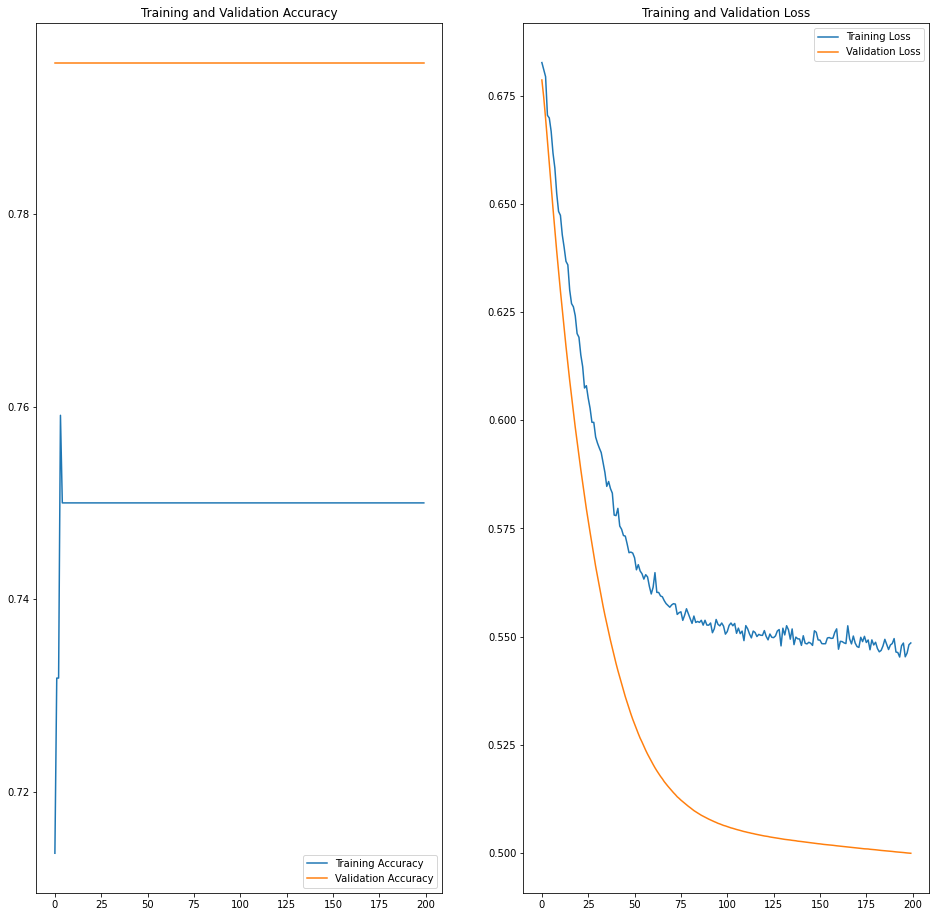

In [101]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [102]:
img = tf.keras.utils.load_img(
    '../data/uab_data/keras/recurrent/CoreID15.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))


1/1 [==============================] - 0s 71ms/step
This image most likely belongs to primary with a 55.14 percent confidence.
